source: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html

/!\ should also check https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html /!\

# The data set
Gelman et al.'s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all county's of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to enter the house through the basement. Moreover, its concentration is thought to differ regionally due to different types of soil.

Here we'll investigate this difference and try to make predictions of radon levels in different countys and where in the house radon was measured. In this example we'll look at Minnesota, a state that contains 85 county's in which different measurements are taken, ranging from 2 till 80 measurements per county.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pymc as pm 
import pandas as pd
import arviz as az

np.random.seed(7)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv('./data/radon.csv')

# use a subset of the counties for faster sampling
# county_names = data['county'].unique()
# select_subset = np.random.randint(0, high=len(county_names), size=3)
# county_names = county_names[select_subset]
county_names = ["CASS", "CROW WING", "FREEBORN"]

data = data[np.any([data['county']==c for c in county_names], axis=0)]
data = data.reset_index(drop=True)

# map counties to index 0,1,2,...
county_idxs, county_names  = pd.factorize(data['county'])
print(len(data))

26


The relevant part of the data we will model looks as follows:

In [3]:
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,CASS,1.335001,0.0
1,CASS,2.014903,0.0
2,CASS,0.693147,0.0
3,CASS,1.686399,0.0
4,CASS,1.410987,0.0


We have multiple radon measurements (log-converted to be on the real line) in a county and whether the measurement has been taken in the basement (floor == 0) or on the first floor (floor == 1). 

**Here we want to test the prediction that radon concentrations are higher in the basement.**

# The Models

## Pooling of measurements

Now you might say: "That's easy! I'll just pool all my data and estimate one big regression to asses the influence of measurement across all counties". In math-speak that model would be:

$$radon_{i, c} = \alpha + \beta*\text{floor}_{i, c} + \epsilon$$

Where $i$ represents the measurement, $c$ the county and floor contains which floor the measurement was made. Critically, we are only estimating one intercept and one slope for all measurements over all counties. The underlying assumption is that **all counties are exactly the same**.

## Separate regressions
But what if we are interested whether different counties actually have different relationships (slope) and different base-rates of radon (intercept)? Then you might say "OK then, I'll just estimate $n$ (number of counties) different regresseions -- one for each county". In math-speak that model would be:

$$radon_{i, c} = \alpha_{c} + \beta_{c}*\text{floor}_{i, c} + \epsilon_c$$

Note that we added the subindex $c$ so we are estimating $n$ different $\alpha$s and $\beta$s -- one for each county.

This is the extreme opposite model, where above we assumed all counties are exactly the same, here we are assuming that **counties share no similarities whatsoever** which ultimately is also unsatisifying.

## Hierarchical Regression: The best of both worlds

Fortunately there is a middle ground to both of these extreme views. Specifically, we may assume that while $\alpha$s and $\beta$s are different for each county, the coefficients all come from a common group distribution:

$$
\begin{align*}
\alpha_{c} & \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2)\\
\beta_{c} & \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2)
\end{align*}
$$

We thus assume the intercepts $\alpha$ and slopes $\beta$ to come from a normal distribution centered around their respective group mean $\mu$ with a certain standard deviation $\sigma^2$, the values (or rather posteriors) of which we also estimate. That's why this is called multilevel or hierarchical modeling.

How do we estimate such a complex model with all these parameters you might ask? Well, that's the beauty of Probabilistic Programming -- we just formulate the model we want and press our *Inference Button*.

Note that the above is not a complete Bayesian model specification as we haven't defined **priors** or **hyperpriors** (i.e. priors for the group distribution, μ and σ). These will be used in the model implementation below but only distract here.

# Probabilistic Programming

## Individual/non-hierarchical model

To really highlight the effect of the hierarchical linear regression we'll first estimate the non-hierarchical Bayesian model from above (separate regressions). For each county a new estimate of the parameters is initiated. As we have no prior information on what the intercept or regressions could be we are placing a Normal distribution centered around 0 with a wide standard-deviation. We'll assume the measurements are normally distributed with noise $\epsilon$ on which we place a Half-Cauchy distribution.

In [4]:
# need to check this
coords = {
    "county": county_names,
    "obs_id": np.arange(len(county_idxs)),
}

In [5]:
with pm.Model(coords=coords) as unpooled_model:
    
    # Independent parameters for each county
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id", mutable=False)
    floor = pm.Data("floor", data['floor'].values, dims="obs_id", mutable=False)
    
    # Intercept prior
    a = pm.Normal('a', mu=0, sigma=100, dims="county")
    # Slope prior
    b = pm.Normal('b', mu=0, sigma=100, dims="county")

    # Model error prior
    eps = pm.HalfCauchy('eps', beta=0.5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx] * floor

    # Data likelihood
    y_like = pm.Normal('y_like', mu=radon_est, sigma=eps, observed=data['log_radon'], dims='obs_id')

    # Inference button
    unpooled_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


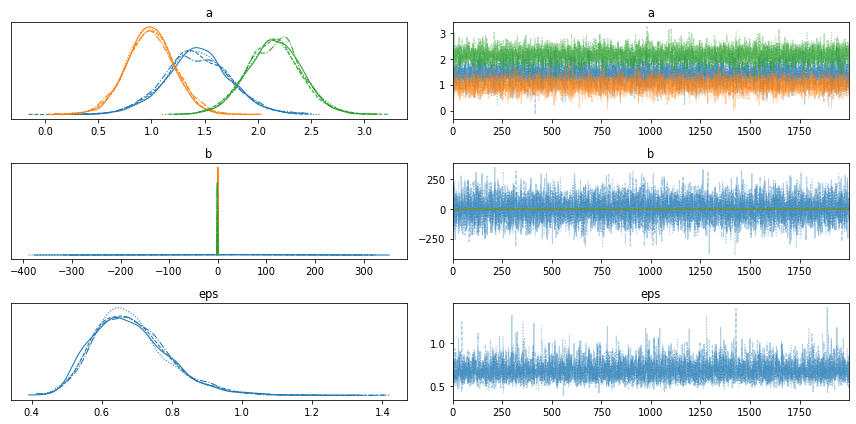

In [20]:
az.plot_trace(unpooled_trace)
plt.tight_layout()
plt.draw()

In [8]:
# pm.model_to_graphviz(unpooled_model)

# Hierarchical Model

Instead of initiating the parameters separatly, the hierarchical model initiates group parameters that consider the county's not as completely different but as having an underlying similarity. These distributions are subsequently used to influence the distribution of each county's $\alpha$ and $\beta$.

In [9]:
with pm.Model(coords=coords) as hierarchical_model:
    county_idx = pm.Data('county_idx', county_idxs, dims='obs_id', mutable=False)
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.0)
    mu_b = pm.Normal('mu_b', mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.0)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length len(county_names)).
    
    # here there should be a reparameterization trick, read more about it here:
    # https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/
    # without reparameterization:
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, dims='county')
    # effect difference between basement and floor level
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, dims='county')
    # and with reparameterization:
    # a_offset = pm.Normal('a_offset', mu=0, sigma=1, dims='county')
    # a = pm.Deterministic('a', mu_a + a_offset * sigma_a)
    # b_offset = pm.Normal('b_offset', mu=0, sigma=1, dims='county')
    # b = pm.Deterministic('b', mu_b + b_offset * sigma_b)
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    # use county_idx to switch to the relevant alpha and beta values for a given data point
    radon_est = a[county_idx] + b[county_idx] * data['floor'].values
    
    # Data likelihood
    y_like = pm.Normal(
        'radon_like', mu=radon_est, sigma=eps, observed=data['log_radon'], dims='obs_id'
    )
    
    # Inference button
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
There were 287 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7675, but should be close to 0.9. Try to increase the number of tuning steps.
There were 332 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8137, but should be close to 0.9. Try to increase the number of tuning steps.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
There were 251 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8009, but should be close to 0.9. Try to increase the number of tuning steps.


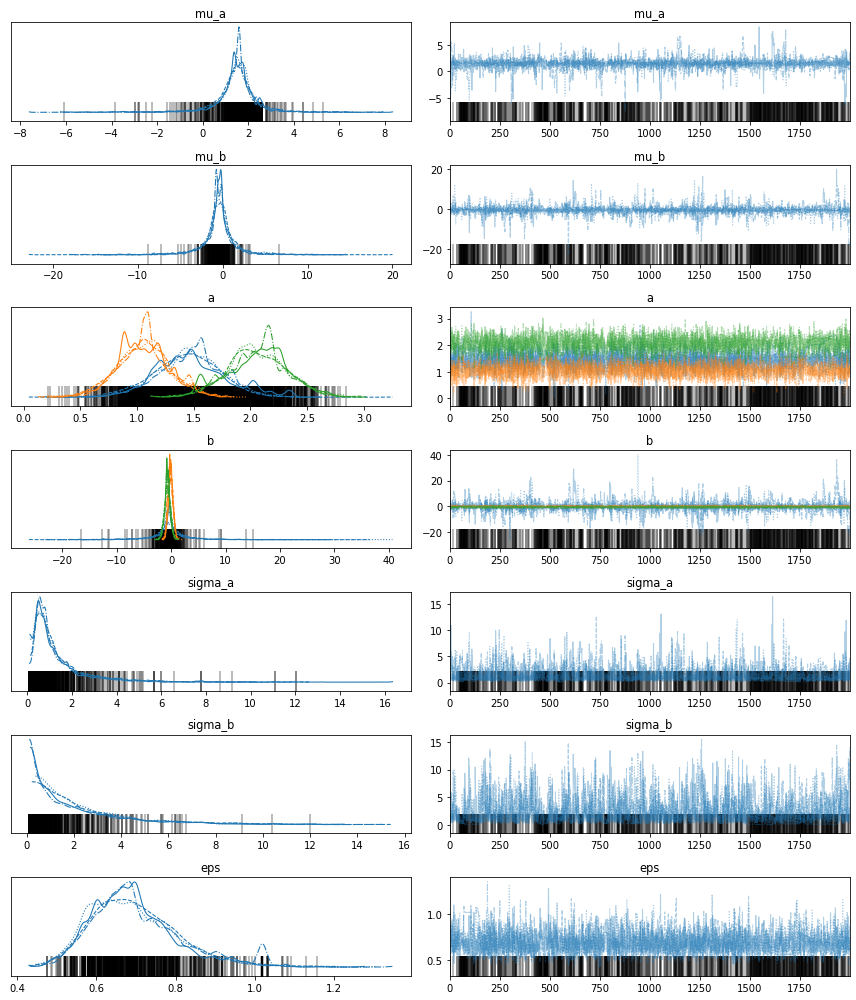

In [10]:
axes_arr = az.plot_trace(hierarchical_trace)
plt.tight_layout()
plt.draw()

The marginal posteriors in the left column are highly informative. $\mu_a$ tells us the group mean (log) radon levels. $\mu_b$ tells us that the slope is significantly negative (no mass above zero), meaning that radon concentrations are higher in the basement than first floor. We can also see by looking at the marginals for a that there is quite some differences in radon levels between counties; the different widths are related to how much measurements we have per county, the more, the higher our confidence in that parameter estimate.

# Posterior Predictive Check

## The Root Mean Square Deviation

To find out which of the models works better we can calculate the Root Mean Square Deviaton (RMSD). This posterior predictive check revolves around recreating the data based on the parameters found at different moments in the chain. The recreated or predicted values are subsequently compared to the real data points, the model that predicts data points closer to the original data is considered the better one. Thus, the lower the RMSD the better.

When computing the RMSD, we can see taht the hierarchical model performs better than the non-hierarchical model in predicting the radon values.

In [11]:
with unpooled_model:
    unpooled_ppc = pm.sample_posterior_predictive(unpooled_trace)

unpooled_rmse = ((unpooled_ppc.posterior_predictive['y_like'] - data['log_radon'].values) ** 2).mean() ** (1/2)

with hierarchical_model:
    hierarchical_ppc = pm.sample_posterior_predictive(hierarchical_trace)

hierarchical_rmse = ((hierarchical_ppc.posterior_predictive['radon_like'] - data['log_radon'].values) ** 2).mean() ** (1/2)

print(f'Individual models RMSE {unpooled_rmse.values}\nHierarchical models RMSE {unpooled_rmse.values}')

Individual models RMSE 0.9630689745654342
Hierarchical models RMSE 0.9630689745654342


Let's plot some examples of county's showing the true radon values, the hierarchial predictions and the non-hierarchical predictions.

In [12]:
xvals = xr.DataArray(np.linspace(-0.2, 1.2, num=85), dims=["x_plot"])

unpooled_post = unpooled_trace.posterior.stack(chain_draw=("chain", "draw"))
hier_post = hierarchical_trace.posterior.stack(chain_draw=("chain", "draw"))

hier_post

<xarray.Dataset>
Dimensions:     (chain_draw: 8000, county: 3)
Coordinates:
  * county      (county) <U9 'CASS' 'CROW WING' 'FREEBORN'
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
Data variables:
    mu_a        (chain_draw) float64 -0.215 3.066 -1.464 ... 1.574 1.828 2.323
    mu_b        (chain_draw) float64 0.7001 1.878 -0.9399 ... -16.28 -18.09
    a           (county, chain_draw) float64 1.747 1.387 1.18 ... 2.494 2.433
    b           (county, chain_draw) float64 6.047 0.8043 3.2 ... -0.964 -0.8453
    sigma_a     (chain_draw) float64 3.463 1.106 2.318 ... 0.8072 2.942 3.847
    sigma_b     (chain_draw) float64 4.383 1.343 3.322 ... 11.93 8.324 14.26
    eps         (chain_draw) float64 0.7332 0.8796 0.5488 ... 0.7456 0.7335
Attributes:
    created_at:                 2022-07-01T13:11:15.200327
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.1
    sampling_time:              32.49149012565613
    tuning_steps:               2000

In [13]:
obs_county = unpooled_post["county"].isel(county=unpooled_trace.constant_data["county_idx"])
observed_data = unpooled_trace.observed_data.assign_coords(
    floor=unpooled_trace.constant_data["floor"]
)

observed_data

<xarray.Dataset>
Dimensions:  (obs_id: 26)
Coordinates:
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 8 9 ... 17 18 19 20 21 22 23 24 25
    floor    (obs_id) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 1.0
Data variables:
    y_like   (obs_id) float64 1.335 2.015 0.6931 1.686 ... 2.588 0.8329 1.74
Attributes:
    created_at:                 2022-07-01T13:08:53.817661
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.1

In [14]:
unpooled_est = (unpooled_post["a"] + unpooled_post["b"] * xvals).transpose("x_plot", ...)
hier_est = (hier_post["a"] + hier_post["b"] * xvals).transpose("x_plot", ...)

In [15]:
rng = np.random.default_rng(0)

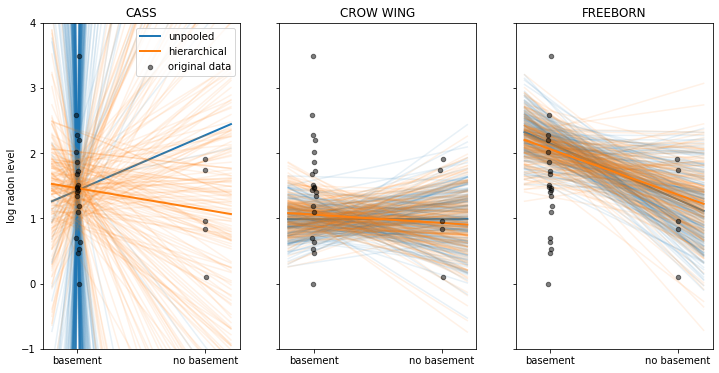

In [16]:
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()

random_subset = rng.permutation(np.arange(len(hier_est["chain_draw"])))[:200]

for i, c in enumerate(county_names):
    ### unpooled model ###
    unpooled_c = unpooled_est.sel(county=c)
    unpooled_means = unpooled_post.sel(county=c).mean()
    # plot all samples from unpooled model
    axis[i].plot(xvals, unpooled_c.isel(chain_draw=random_subset), color="C0", alpha=0.1)
    # plot mean from unpooled model
    axis[i].plot(
        xvals,
        unpooled_means["a"] + unpooled_means["b"] * xvals,
        color="C0",
        alpha=1,
        lw=2.0,
        label="unpooled",
    )
    ### hierarchical model ##
    hier_c = hier_est.sel(county=c)
    hier_means = hier_post.sel(county=c).mean()
    # plot all samples
    axis[i].plot(xvals, hier_c.isel(chain_draw=random_subset), color="C1", alpha=0.1)
    # plot mean
    axis[i].plot(
        xvals,
        hier_means["a"] + hier_means["b"] * xvals,
        color="C1",
        alpha=1,
        lw=2.0,
        label="hierarchical",
    )
    # observed_data
    obs_data_c = observed_data.where(obs_county.isin(county_names), drop=True)
    axis[i].scatter(
        obs_data_c["floor"] + rng.normal(scale=0.01, size=len(obs_data_c["floor"])),
        obs_data_c["y_like"],
        alpha=0.5,
        color="k",
        marker=".",
        s=80,
        zorder=3,
        label="original data",
    )
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["basement", "no basement"])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel("log radon level")

In the above plot we have the data points in black of three selected counties. The thick lines represent the mean estimate of the regression line of the individual (blue) and hierarchical model (in green). The thinner lines are regression lines of individual samples from the posterior and give us a sense of how variable the estimates are.

When looking at the county ‘CASS’ we see that the non-hierarchical estimation is strongly biased: as this county’s data contains only households with a basement the estimated regression produces the non-sensical result of a giant negative slope meaning that we would expect negative radon levels in a house without basement!

Moreover, in the example county’s ‘CROW WING’ and ‘FREEBORN’ the non-hierarchical model appears to react more strongly than the hierarchical model to the existance of outliers in the dataset (‘CROW WING’: no basement upper right. ‘FREEBORN’: basement upper left). Assuming that there should be a higher amount of radon gas measurable in households with basements opposed to those without, the county ‘CROW WING’’s non-hierachical model seems off. Having the group-distribution constrain the coefficients we get meaningful estimates in all cases as we apply what we learn from the group to the individuals and vice-versa.

# Shrinkage¶

Shrinkage describes the process by which our estimates are “pulled” towards the group-mean as a result of the common group distribution – county-coefficients very far away from the group mean have very low probability under the normality assumption, moving them closer to the group mean gives them higher probability. In the non-hierachical model every county is allowed to differ completely from the others by just using each county’s data, resulting in a model more prone to outliers (as shown above).



In [17]:
hier_a = hier_post["a"].mean("chain_draw")
hier_b = hier_post["b"].mean("chain_draw")
unpooled_a = unpooled_post["a"].mean("chain_draw")
unpooled_b = unpooled_post["b"].mean("chain_draw")

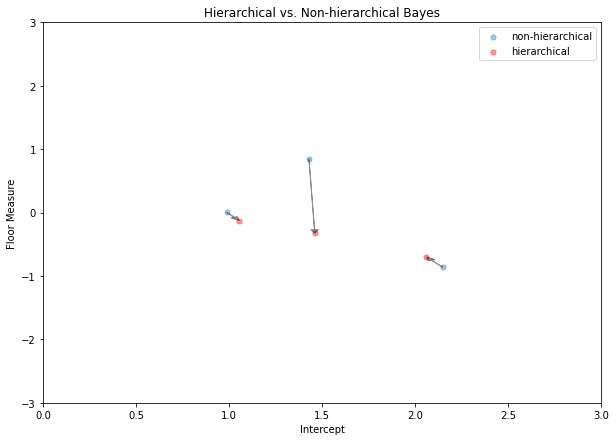

In [18]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(
    111,
    xlabel="Intercept",
    ylabel="Floor Measure",
    title="Hierarchical vs. Non-hierarchical Bayes",
    xlim=(0, 3),
    ylim=(-3, 3),
)

ax.scatter(unpooled_a, unpooled_b, s=26, alpha=0.4, label="non-hierarchical")
ax.scatter(hier_a, hier_b, c="red", s=26, alpha=0.4, label="hierarchical")
for i in range(len(hier_b)):
    ax.arrow(
        unpooled_a[i],
        unpooled_b[i],
        hier_a[i] - unpooled_a[i],
        hier_b[i] - unpooled_b[i],
        fc="k",
        ec="k",
        length_includes_head=True,
        alpha=0.4,
        head_width=0.04,
    )
ax.legend()